### Dependencies & Prerequisites

<div class="alert alert-success">
    Tensorflow Probability is part of the colab default runtime, <b>so you don't need to install Tensorflow or Tensorflow Probability if you're running this in the colab</b>. 
    <br>
    If you're running this notebook in Jupyter on your own machine (and you have already installed Tensorflow), you can use the following
    <br>
      <ul>
    <li> For the most recent nightly installation: <code>pip3 install -q tfp-nightly</code></li>
    <li> For the most recent stable TFP release: <code>pip3 install -q --upgrade tensorflow-probability</code></li>
    <li> For the most recent stable GPU-connected version of TFP: <code>pip3 install -q --upgrade tensorflow-probability-gpu</code></li>
    <li> For the most recent nightly GPU-connected version of TFP: <code>pip3 install -q tfp-nightly-gpu</code></li>
    </ul>
Again, if you are running this in a Colab, Tensorflow and TFP are already installed
</div>

In [1]:
#@title Imports and Global Variables (make sure to run this cell)  { display-mode: "form" }

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
      pass


from __future__ import absolute_import, division, print_function


#@markdown This sets the warning status (default is `ignore`, since this notebook runs correctly)
warning_status = "ignore" #@param ["ignore", "always", "module", "once", "default", "error"]
import warnings
warnings.filterwarnings(warning_status)
with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

    
#M.S.> had to uninstall numpy via pip and reinstall via conda (v.1.18.5)
import numpy as np
import pandas as pd
import os
#@markdown This sets the styles of the plotting (default is styled like plots from [FiveThirtyeight.com](https://fivethirtyeight.com/)
matplotlib_style = 'fivethirtyeight' #@param ['fivethirtyeight', 'bmh', 'ggplot', 'seaborn', 'default', 'Solarize_Light2', 'classic', 'dark_background', 'seaborn-colorblind', 'seaborn-notebook']
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import matplotlib.axes as axes;
from matplotlib.patches import Ellipse
#%matplotlib inline
import seaborn as sns; sns.set_context('notebook')
from IPython.core.pylabtools import figsize
#@markdown This sets the resolution of the plot outputs (`retina` is the highest resolution)
notebook_screen_res = 'retina' #@param ['retina', 'png', 'jpeg', 'svg', 'pdf']
#%config InlineBackend.figure_format = notebook_screen_res

import tensorflow as tf

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.config
    gpu_devices = config.experimental.list_physical_devices('GPU')
    if enable_gpu_ram_resizing:
        for device in gpu_devices:
            tf.config.experimental.set_memory_growth(device, True)
    if enable_xla:
        config.optimizer.set_jit(True)
    return config

session_options(enable_gpu_ram_resizing=True, enable_xla=True)

<module 'tensorflow._api.v2.config' from 'C:\\Users\\maris\\anaconda3\\envs\\tfp-env\\lib\\site-packages\\tensorflow\\_api\\v2\\config\\__init__.py'>

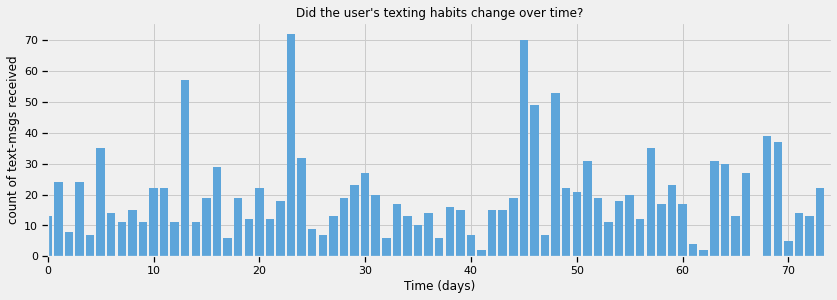

In [2]:
# Defining our Data and assumptions
count_data = tf.constant([
    13,  24,   8,  24,   7,  35,  14,  11,  15,  11,  22,  22,  11,  57,  
    11,  19,  29,   6,  19,  12,  22,  12,  18,  72,  32,   9,   7,  13,  
    19,  23,  27,  20,   6,  17,  13,  10,  14,   6,  16,  15,   7,   2,  
    15,  15,  19,  70,  49,   7,  53,  22,  21,  31,  19,  11,  18,  20,  
    12,  35,  17,  23,  17,   4,   2,  31,  30,  13,  27,   0,  39,  37,   
    5,  14,  13,  22,
], dtype=tf.float32)

n_count_data = tf.shape(count_data)
days = tf.range(n_count_data[0],dtype=tf.int32)

# Visualizing the Results
plt.figure(figsize=(12.5, 4))
plt.bar(days.numpy(), count_data, color="#5DA5DA")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data[0].numpy());

In [3]:
def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    tfd = tfp.distributions
 
    alpha = (1. / tf.reduce_mean(count_data))
    rv_lambda_1 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
 
    rv_tau = tfd.Uniform()
 
    lambda_ = tf.gather(
         [lambda_1, lambda_2],
         indices=tf.cast(tau * tf.cast(tf.size(count_data), dtype=tf.float32) <= tf.cast(tf.range(tf.size(count_data)), dtype=tf.float32), dtype=tf.int32))
    rv_observation = tfd.Poisson(rate=lambda_)
 
    return (
         rv_lambda_1.log_prob(lambda_1)
         + rv_lambda_2.log_prob(lambda_2)
         + rv_tau.log_prob(tau)
         + tf.reduce_sum(rv_observation.log_prob(count_data))
    )


# Define a closure over our joint_log_prob.
def unnormalized_log_posterior(lambda1, lambda2, tau):
    return joint_log_prob(count_data, lambda1, lambda2, tau)


## Specify the posterior sampler

In [4]:
# wrap the mcmc sampling call in a @tf.function to speed it up
@tf.function(autograph=False)
def graph_sample_chain(*args, **kwargs):
    return tfp.mcmc.sample_chain(*args, **kwargs)

num_burnin_steps = 5000
(num_results) = 20000


# Set the chain's start state.
initial_chain_state = [
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda1"),
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name="init_lambda2"),
    0.5 * tf.ones([], dtype=tf.float32, name="init_tau"),
]


# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Exp(),       # Maps a positive real to R.
    tfp.bijectors.Sigmoid(),   # Maps [0,1] to R.  
]

step_size = 0.2

kernel=tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            num_leapfrog_steps=2,
            step_size=step_size,
            state_gradients_are_stopped=True),
        bijector=unconstraining_bijectors)

kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8))


# Sample from the chain.
[
    lambda_1_samples,
    lambda_2_samples,
    posterior_tau,
], kernel_results = graph_sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_chain_state,
    kernel = kernel)
    
tau_samples = tf.floor(posterior_tau * tf.cast(tf.size(count_data),dtype=tf.float32))

In [5]:
print("acceptance rate: {}".format(
    tf.reduce_mean(tf.cast(kernel_results.inner_results.inner_results.is_accepted,dtype=tf.float32))))
print("final step size: {}".format(
    tf.reduce_mean(kernel_results.inner_results.inner_results.accepted_results.step_size[-100:])))


acceptance rate: 0.5784500241279602
final step size: 0.030197447165846825


## Plot the Results

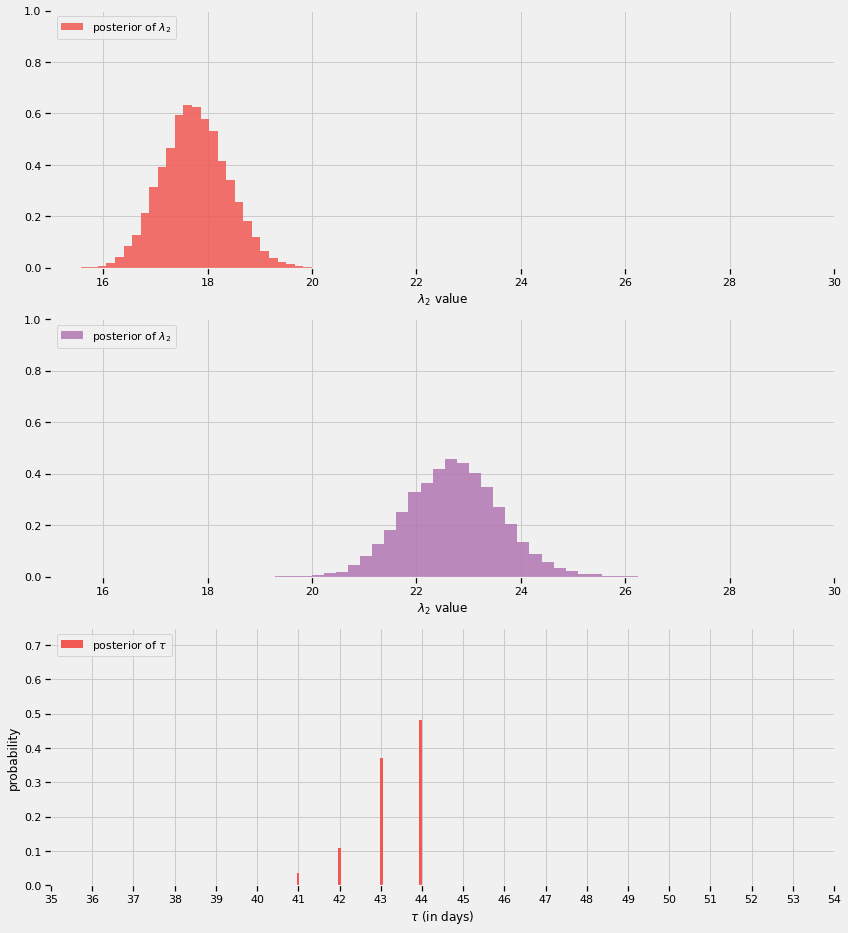

In [78]:
plt.figure(figsize=(12.5, 15))
#histogram of the samples:

#M.S.>Convert Eagar Tensor to np.array() to use plt.hist()
ax = plt.subplot(311)
ax.set_autoscaley_on(False)
np_array_of_tensor_1 = np.array(lambda_1_samples);
plt.hist(np_array_of_tensor_1, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_2$",color=TFColor[0], density=True )
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel(r"$\lambda_2$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
np_array_of_tensor_2 = np.array(lambda_2_samples);
plt.hist(np_array_of_tensor_2, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_2$", color=TFColor[6], density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel(r"$\lambda_2$ value")

plt.subplot(313)
np_array_of_tensor_tau = np.array(tau_samples);
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples);
plt.hist(np_array_of_tensor_tau, bins=n_count_data[0], alpha=1,
         label=r"posterior of $\tau$",
         color=TFColor[0], weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data[0]))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel(r"probability");

## Interpretation

Recall that Bayesian methodology returns a *distribution*. Hence we now have distributions to describe the unknown $\lambda$s and $\tau$. What have we gained? Immediately, we can see the uncertainty in our estimates: the wider the distribution, the less certain our posterior belief should be. We can also see what the plausible values for the parameters are: $\lambda_1$ is around 18 and $\lambda_2$ is around 23. The posterior distributions of the two $\lambda$s are clearly distinct, indicating that it is indeed likely that there was a change in the user's text-message behaviour.

What other observations can you make? If you look at the original data again, do these results seem reasonable? 

Notice also that the posterior distributions for the $\lambda$s do not look like exponential distributions, even though our priors for these variables were exponential. In fact, the posterior distributions are not really of any form that we recognize from the original model. But that's OK! This is one of the benefits of taking a computational point of view. If we had instead done this analysis using mathematical approaches, we would have been stuck with an analytically intractable (and messy) distribution. Our use of a computational approach makes us indifferent to mathematical tractability.
 
Our analysis also returned a distribution for $\tau$. Its posterior distribution looks a little different from the other two because it is a discrete random variable, so it doesn't assign probabilities to intervals. We can see that near day 45, there was a 50% chance that the user's behaviour changed. Had no change occurred, or had the change been gradual over time, the posterior distribution of $\tau$ would have been more spread out, reflecting that many days were plausible candidates for $\tau$. By contrast, in the actual results we see that only three or four days make any sense as potential transition points. 

### Why would I want samples from the posterior, anyways?

We will deal with this question for the remainder of the book, and it is an understatement to say that it will lead us to some amazing results. For now, let's end this chapter with one more example.

We'll use the posterior samples to answer the following question: what is the expected number of texts at day $t, \; 0 \le t \le 70$ ? Recall that the expected value of a Poisson variable is equal to its parameter $\lambda$. Therefore, the question is equivalent to *what is the expected value of $\lambda$ at time $t$*?
 
In the code below, let $i$ index samples from the posterior distributions. Given a day $t$, we average over all possible $\lambda_i$ for that day $t$, using $\lambda_i = \lambda_{1,i}$ if $t \lt \tau_i$ (that is, if the behaviour change has not yet occurred), else we use $\lambda_i = \lambda_{2,i}$. 


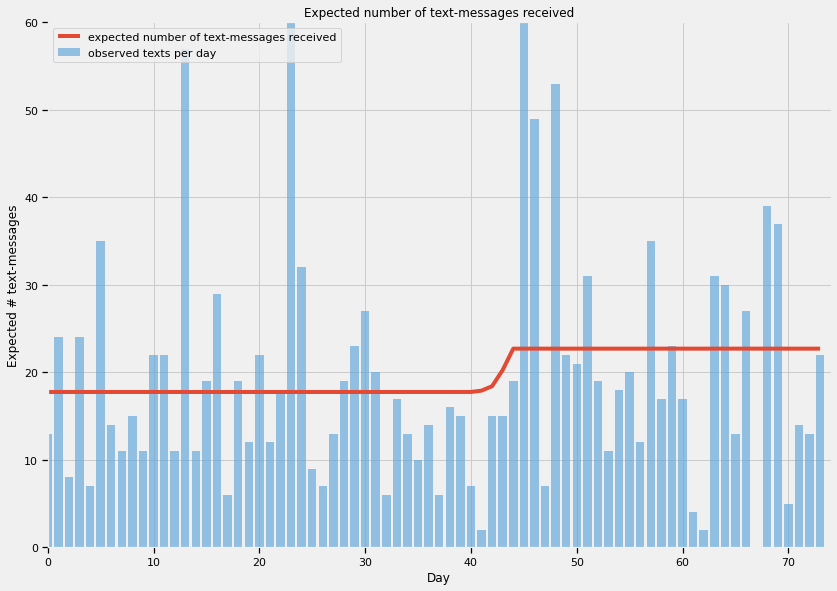

In [76]:
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution

N_ = tau_samples.shape[0]
expected_texts_per_day = tf.zeros(N_,n_count_data.shape[0]) #(10000,74)

plt.figure(figsize=(12.5, 9))

day_range = tf.range(0,n_count_data[0],delta=1,dtype = tf.int32)

# expand from shape of 74 to (10000,74)
day_range = tf.expand_dims(day_range,0)
day_range = tf.tile(day_range,tf.constant([N_,1]))

# expand from shape of 10000 to 10000,74
tau_samples_per_day = tf.expand_dims(tau_samples,0)
tau_samples_per_day = tf.transpose(tf.tile(tau_samples_per_day,tf.constant([day_range.shape[1],1])))

tau_samples_per_day = tf.cast(tau_samples_per_day,dtype=tf.int32)
#ix_day is (10000,74) tensor where axis=0 is number of samples, axis=1 is day. each value is true iff sampleXday value is < tau_sample value
ix_day = day_range < tau_samples_per_day

lambda_1_samples_per_day = tf.expand_dims(lambda_1_samples,0)
lambda_1_samples_per_day = tf.transpose(tf.tile(lambda_1_samples_per_day,tf.constant([day_range.shape[1],1])))
lambda_2_samples_per_day = tf.expand_dims(lambda_2_samples,0)
lambda_2_samples_per_day = tf.transpose(tf.tile(lambda_2_samples_per_day,tf.constant([day_range.shape[1],1])))

expected_texts_per_day = ((tf.reduce_sum(lambda_1_samples_per_day*tf.cast(ix_day,dtype=tf.float32),axis=0) + tf.reduce_sum(lambda_2_samples_per_day*tf.cast(~ix_day,dtype=tf.float32),axis=0))/N_)

plt.plot(range(n_count_data[0]), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data.numpy()[0])
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#5DA5DA", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");